In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from dash import Dash, html, dcc, callback, Output, Input, jupyter_dash
import plotly.express as px


In [2]:
# Load the invoice data from the CSV file
invoice_data = pd.read_csv("Data Ops Analyst Task.csv")

# Display the first few rows of the dataset to understand its structure
invoice_data.head()

,id,total_amount,amount_due,issue_date,due_date,paid_on_date,payer_id
0,1,1720329,0.0,2021-11-01 00:00:00.000000 UTC,2021-12-31 00:00:00.000000 UTC,2022-08-22 00:00:00.000000 UTC,pKey9MQ59wyF6GhjWM5p
1,2,1560727,0.0,2021-11-01 00:00:00.000000 UTC,2021-12-01 00:00:00.000000 UTC,2021-12-04 00:00:00.000000 UTC,Ed9wuAC3RlOfWkENchdD
2,3,149600,0.0,2021-11-01 00:00:00.000000 UTC,2022-02-14 00:00:00.000000 UTC,2022-02-22 00:00:00.000000 UTC,bPBZIvFiIE1ZbZjvuYm7
3,4,149600,0.0,2021-11-01 00:00:00.000000 UTC,2022-02-14 00:00:00.000000 UTC,2022-02-22 00:00:00.000000 UTC,bPBZIvFiIE1ZbZjvuYm7
4,5,149600,0.0,2021-11-01 00:00:00.000000 UTC,2022-02-14 00:00:00.000000 UTC,2022-02-22 00:00:00.000000 UTC,bPBZIvFiIE1ZbZjvuYm7


In [3]:
# Summary statistics of the numerical columns
invoice_data.describe()

,id,total_amount,amount_due
count,17692.000000,1.769200e+04,1.769200e+04
mean,8846.500000,3.593852e+05,1.165280e+05
std,5107.384817,6.711405e+05,4.492811e+05
min,1.000000,2.800000e+01,0.000000e+00
25%,4423.750000,4.021300e+04,0.000000e+00
50%,8846.500000,9.837550e+04,0.000000e+00
75%,13269.250000,2.675588e+05,2.100000e+04
max,17692.000000,1.407881e+07,1.246271e+07


In [4]:

# Check for missing values
invoice_data.isnull().sum()

id                 0
total_amount       0
amount_due         0
issue_date         0
due_date           0
paid_on_date    4763
payer_id           0
dtype: int64

In [5]:
# Check for duplicate data
invoice_data.duplicated().sum()

0

# 1. How should we categorise the payers into different categories based on a coherent logic?

Categorizing payer into different categories involves analyzing their payment behaviours and creating distinct groups based on relevant criteria.


## Major Categories of Payer

1. **Paid On Time Payer:**
   - Pays within the specified timeframe or on the due date.

2. **Delay Payer:**
   - Faces delays in payment.

3. **Not Paid Payer:**
   - Does not make payments within a reasonable timeframe, requiring special attention and follow-up.

## Delay Subcategories (Future Consideration)

For future enhancements, delays can be further categorized based on the number of days beyond the due date:

- **Regular Delay:**
  - Delay of 1-7 days beyond the due date.

- **Occasional Delay:**
  - Delay of 8-14 days beyond the due date.

- **Intermediate Delay:**
  - Delay of 15-30 days beyond the due date.

- **Significant Delay:**
  - Delay of 31 days or more beyond the due date.

## Current Approach

At present, the focus is on identifying delays without further categorization based on the number of days. The emphasis is on sending reminders and maintaining regular follow-ups to encourage timely payments.

## Usage

1. **Integration:**
   - Integrate the payer categorization system into your existing payment management system.

2. **Categorization:**
   - Categorize payers based on their payment behavior.

3. **Follow-Up:**
   - Implement regular follow-ups and reminders for delay payers.


In [6]:
df = invoice_data
# Convert date columns to datetime objects
df['issue_date'] = pd.to_datetime(df['issue_date'])
df['due_date'] = pd.to_datetime(df['due_date'])
df['paid_on_date'] = pd.to_datetime(df['paid_on_date'])

In [7]:
#  categorise the Invoice into different categories based on a coherent logic

def categorize_invoice(row):
    paid_on_date = row['paid_on_date']
    due_date = row['due_date']

    if pd.notnull(paid_on_date):
        delay_days = (paid_on_date - due_date).days

        if delay_days <= 0:
            return 'Paid on time Invoice'
        elif delay_days > 0:
            return 'Delay paid Invoice'
    else:
        return 'Not paid Invoice'

# Apply the categorization function to create a new column 'invoice_category'
df['invoice_category'] = df.apply(categorize_invoice, axis=1)


# Display the categorized data
print(df[['payer_id', 'invoice_category']])

                   payer_id      invoice_category
0      pKey9MQ59wyF6GhjWM5p    Delay paid Invoice
1      Ed9wuAC3RlOfWkENchdD    Delay paid Invoice
2      bPBZIvFiIE1ZbZjvuYm7    Delay paid Invoice
3      bPBZIvFiIE1ZbZjvuYm7    Delay paid Invoice
4      bPBZIvFiIE1ZbZjvuYm7    Delay paid Invoice
...                     ...                   ...
17687  91QYdKB0Rp8Ycw5kJahR    Delay paid Invoice
17688  A3NQynMOlLGXICiXW86Q      Not paid Invoice
17689  NF2WnDtKnpYIlqslEH3b  Paid on time Invoice
17690  8ODa2O9Ll6BRqaxcfheK  Paid on time Invoice
17691  NiKaIPB15ArvJcpFfEe1      Not paid Invoice

[17692 rows x 2 columns]


In [8]:
#  categorise the payer into different categories based on a invoice category

result = df.groupby(['payer_id', 'invoice_category']).size().reset_index(name='category_count')

# Creating a dictionary for each payer with category and count information
output_dict = {}
for index, row in result.iterrows():
    payer_id = row['payer_id']
    category = row['invoice_category']
    count = row['category_count']

    if payer_id not in output_dict:
        output_dict[payer_id] = {}

    output_dict[payer_id][category] = count

# Creating a new column 'final_category'
df['payer_category'] = df['payer_id'].apply(lambda x: max(output_dict[x], key=output_dict[x].get) if x in output_dict and output_dict[x] else 'Not categorized')
df['payer_category'] = df['payer_category'].str.replace('Invoice', 'Payer')

# Displaying the result in the desired format
for payer_id, categories in output_dict.items():
    print(f"{payer_id}\t{categories}\tPayer Category: {df[df['payer_id'] == payer_id]['payer_category'].iloc[0]}")

02XogYMYtYTC5RnqM2hW	{'Delay paid Invoice': 10, 'Paid on time Invoice': 1}	Payer Category: Delay paid Payer
0APxoWmvM8WtnUMozFsK	{'Delay paid Invoice': 6}	Payer Category: Delay paid Payer
0Df7OekBKNYtNfrCkXyi	{'Not paid Invoice': 3, 'Paid on time Invoice': 8}	Payer Category: Paid on time Payer
0KOfWDjA1suUKTaywOEN	{'Delay paid Invoice': 4}	Payer Category: Delay paid Payer
0KPQJe8MtJYgyNJvHZ4t	{'Delay paid Invoice': 1, 'Paid on time Invoice': 1}	Payer Category: Delay paid Payer
0LeTGafQ6aAwsqsSk7JQ	{'Delay paid Invoice': 18, 'Not paid Invoice': 2}	Payer Category: Delay paid Payer
0Wi5xw8wHXUdeXDXMIYz	{'Delay paid Invoice': 29, 'Not paid Invoice': 49}	Payer Category: Not paid Payer
0ZSIej5ITw7z91r9uAfH	{'Delay paid Invoice': 37, 'Paid on time Invoice': 33}	Payer Category: Delay paid Payer
0cfsecX5PFKjTBEQuku3	{'Delay paid Invoice': 6, 'Paid on time Invoice': 66}	Payer Category: Paid on time Payer
0dzUpnvukCNsnGeo084T	{'Delay paid Invoice': 10, 'Not paid Invoice': 2}	Payer Category: Delay

In [9]:
df.head()

,id,total_amount,amount_due,issue_date,due_date,paid_on_date,payer_id,invoice_category,payer_category
0,1,1720329,0.0,2021-11-01 00:00:00+00:00,2021-12-31 00:00:00+00:00,2022-08-22 00:00:00+00:00,pKey9MQ59wyF6GhjWM5p,Delay paid Invoice,Delay paid Payer
1,2,1560727,0.0,2021-11-01 00:00:00+00:00,2021-12-01 00:00:00+00:00,2021-12-04 00:00:00+00:00,Ed9wuAC3RlOfWkENchdD,Delay paid Invoice,Delay paid Payer
2,3,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer
3,4,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer
4,5,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer


In [10]:
# Calculate days delinquent
df['days_delinquent'] = (df['paid_on_date'] - df['due_date']).fillna(pd.Timedelta(days=365)).dt.days

In [11]:
df.head()

,id,total_amount,amount_due,issue_date,due_date,paid_on_date,payer_id,invoice_category,payer_category,days_delinquent
0,1,1720329,0.0,2021-11-01 00:00:00+00:00,2021-12-31 00:00:00+00:00,2022-08-22 00:00:00+00:00,pKey9MQ59wyF6GhjWM5p,Delay paid Invoice,Delay paid Payer,234
1,2,1560727,0.0,2021-11-01 00:00:00+00:00,2021-12-01 00:00:00+00:00,2021-12-04 00:00:00+00:00,Ed9wuAC3RlOfWkENchdD,Delay paid Invoice,Delay paid Payer,3
2,3,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8
3,4,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8
4,5,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8


# Visualization of payer categories

The Below visulization display Categories of payer and there invoice categories based on the Payer_id


In [12]:
app = Dash(__name__)

# Define layout of the app
app.layout = html.Div([
    html.H1("Payer Category Details Dashboard"),
    
    dcc.Graph(id='data-plot'),

    dcc.Dropdown(
        id='payer-id-dropdown',
        options=[
            {'label': payer_id, 'value': payer_id} for payer_id in df['payer_id'].unique()
        ],
        multi=True,
        style={'width': '50%'},
        placeholder='Select Payer ID(s)'
    ),

    dcc.Dropdown(
        id='payer-category-dropdown',
        options=[
            {'label': category, 'value': category} for category in df['payer_category'].unique()
        ],
        multi=True,
        style={'width': '50%'},
        placeholder='Select Payer Category(s)'
    ),

    dcc.Dropdown(
        id='invoice-category-dropdown',
        options=[
            {'label': invoice_category, 'value': invoice_category} for invoice_category in df['invoice_category'].unique()
        ],
        multi=True,
        style={'width': '50%'},
        placeholder='Select Invoice Category(s)'
    )
])

# Define callback to update plot based on selected payer_id, payer_category, and invoice_category
@app.callback(
    Output('data-plot', 'figure'),
    [Input('payer-id-dropdown', 'value'),
     Input('payer-category-dropdown', 'value'),
     Input('invoice-category-dropdown', 'value')]
)
def update_data_plot(selected_payer_ids, selected_categories, selected_invoice_categories):
    # If all dropdowns are selected, filter the DataFrame accordingly
    if selected_payer_ids and selected_categories and selected_invoice_categories:
        filtered_df = df[
            (df['payer_id'].isin(selected_payer_ids)) &
            (df['payer_category'].isin(selected_categories)) &
            (df['invoice_category'].isin(selected_invoice_categories))
        ]
        title = f'Data for Selected Payer IDs, Categories, and Invoice Categories'
    elif selected_payer_ids and selected_categories:
        # If payer_id and payer_category dropdowns are selected, filter the DataFrame accordingly
        filtered_df = df[
            (df['payer_id'].isin(selected_payer_ids)) &
            (df['payer_category'].isin(selected_categories))
        ]
        title = f'Data for Selected Payer IDs and Categories'
    elif selected_payer_ids and selected_invoice_categories:
        # If payer_id and invoice_category dropdowns are selected, filter the DataFrame accordingly
        filtered_ml_df = df[
            (df['payer_id'].isin(selected_payer_ids)) &
            (df['invoice_category'].isin(selected_invoice_categories))
        ]
        title = f'Data for Selected Payer IDs and Invoice Categories'
    elif selected_categories and selected_invoice_categories:
        # If payer_category and invoice_category dropdowns are selected, filter the DataFrame accordingly
        filtered_df = df[
            (df['payer_category'].isin(selected_categories)) &
            (df['invoice_category'].isin(selected_invoice_categories))
        ]
        title = f'Data for Selected Categories and Invoice Categories'
    elif selected_payer_ids:
        # If only payer_id dropdown is selected, filter the DataFrame accordingly
        filtered_df = df[df['payer_id'].isin(selected_payer_ids)]
        title = f'Data for Selected Payer IDs'
    elif selected_categories:
        # If only payer_category dropdown is selected, filter the DataFrame accordingly
        filtered_df = df[df['payer_category'].isin(selected_categories)]
        title = f'Data for Selected Payer Categories'
    elif selected_invoice_categories:
        # If only invoice_category dropdown is selected, filter the DataFrame accordingly
        filtered_df = df[df['invoice_category'].isin(selected_invoice_categories)]
        title = f'Data for Selected Invoice Categories'
    else:
        # If none is selected, show counts for all payer_category and invoice_category
        filtered_df = df
        title = f'Counts for All Payers, Categories, and Invoice Categories'
    
    # Create scatter plot with hover information
    if 'days_delinquent' in filtered_df.columns:
        fig = px.scatter(
            filtered_df,
            x='payer_id',
            y='days_delinquent',
            color='invoice_category',
            hover_data=['invoice_category'],
            title=title
        )
    else:
        category_counts = filtered_df['payer_category'].value_counts().reset_index()
        category_counts.columns = ['payer_category', 'count']
        fig = px.bar(category_counts, x='payer_category', y='count', title=title)

    return fig

# Run the app inline in a Jupyter Notebook
app.run_server(mode='inline', port=8049)

# 2.What are the recommendations for the reminders schedule (Accounts receivable collections) with these different sets of payers to improve collection efficiency?


1. **Segmentation and Categorization:**
   - Utilize the existing `payer_category` and `invoice_category` fields to create detailed segments based on both payer behavior and invoice characteristics. Understand how different combinations impact payment patterns.

2. **Days Delinquent Analysis:**
   - Analyze the `days_delinquent` field to understand the average delay in payment for each combination of payer and invoice categories. Identify outliers and trends to tailor strategies accordingly.

3. **Invoice Due Date Adjustment:**
   - Adjust future invoice due dates based on historical payment patterns for each payer and invoice category. Align due dates with the typical payment behavior of specific payer and invoice combinations to reduce delays.

4. **Automated Reminder Systems:**
   - Implement automated reminder systems with customized timing and frequency based on payer and invoice categories. Send reminders as the due date approaches, considering the specific characteristics of each combination.

5. **Early Payment Incentives:**
   - Consider offering early payment incentives for specific combinations of payer and invoice categories. Develop a tiered incentive system to encourage prompt payments based on the unique attributes of each combination.

6. **Communication and Relationship Building:**
   - Establish clear communication channels with payers for each payer and invoice category combination. Understand their challenges and collaborate to find tailored solutions that address the specific dynamics of each segment.

7. **Flexible Payment Plans:**
   - Offer flexible payment plans for payers with a history of delays, considering the specific invoice categories involved. Tailor these plans to the unique circumstances of each payer and invoice combination.

8. **Regular Reporting and Analysis:**
   - Generate regular reports to monitor the effectiveness of collection strategies for different payer and invoice categories. Analyze payer behavior and payment trends to make informed adjustments to the collection approach.

9. **Escalation Procedures:**
   - Define escalation procedures for persistent late payments based on payer and invoice categories. Gradually increase the intensity of reminders and consider engaging legal or collection agencies if necessary.

10. **Customer Feedback and Continuous Improvement:**
    - Collect feedback from customers regarding invoicing and payment processes, considering both payer and invoice categories. Use this feedback to identify areas for improvement and implement changes to optimize the collection process continuously.


# 3. What are some insights we can derive on the payers and their payment behavior?

## 1. Top Delinquent Payers
## 2. Payer-specific Payment Patterns
## 3. Variability in Days Delinquent Across Categories
## 4. Payment Trends Over Months for Each Payer Category
## 5. Payment Trends Over Months for Each Payer
## 6. Payment Patterns for Each Invoice Category
## 7. Identify Payers with Improving or Deteriorating Payment Trends

In [13]:
## 1. Top Delinquent Payers

# Exclude payers with exactly 365 days delay
fdf = filtered_delinquent_payers = df[df['days_delinquent'] != 365]

# Find the top delinquent payers
top_delinquent_payers = filtered_delinquent_payers.groupby('payer_id')['days_delinquent'].max().nlargest(5)

print("\nTop Delinquent Payers (excluding 365 days):")
print(top_delinquent_payers)


Top Delinquent Payers (excluding 365 days):
payer_id
pKey9MQ59wyF6GhjWM5p    329
lbHQFdZcUoXpNQK9lcFy    327
NAjIqWHdkYIerr4y239b    306
WnhWusL5dB6NIxrTWCND    295
D3vAhqrA3IiD6xn0LOJ1    292
Name: days_delinquent, dtype: int64


In [14]:
## 2. Payer-specific Payment Patterns

payer_payment_patterns = fdf.groupby('payer_id')['days_delinquent'].mean()

# Convert to string with a max width to make it scrollable
output_string = payer_payment_patterns.to_string(max_rows=len(payer_payment_patterns))

print("\nPayer-specific Payment Patterns:")
print(output_string)


Payer-specific Payment Patterns:
payer_id
02XogYMYtYTC5RnqM2hW     39.545455
0APxoWmvM8WtnUMozFsK     37.666667
0Df7OekBKNYtNfrCkXyi    -39.875000
0KOfWDjA1suUKTaywOEN      2.500000
0KPQJe8MtJYgyNJvHZ4t     -9.500000
0LeTGafQ6aAwsqsSk7JQ    150.666667
0Wi5xw8wHXUdeXDXMIYz     20.620690
0ZSIej5ITw7z91r9uAfH      1.328571
0cfsecX5PFKjTBEQuku3     -9.236111
0dzUpnvukCNsnGeo084T     74.900000
0fav4IMU83cEbqzZ42bl     12.533333
0jTejTjL8qXIzWgipWzP     -2.000000
0neJhKmnbrtdcCgSbaKo      2.157895
0p6q6FKfr6MXcJHiCYRZ     30.600000
0zKN6TR7WP8eagCUg4P4     21.333333
126Nv7oVPdMH4KUn0945     53.714286
15T2G5n6MZ3UQUPztkuJ    143.000000
17tbdeXoDQKMqc4xOXya      3.000000
1EFMYl6hw6777jpa0esk     24.500000
1MWNaWuKJqmRneBlZa8Y     10.000000
1MdjiaYI7J755GyFhkiv     82.250000
1Nof07KM8Rlpb6DwQG4l     -3.807692
1NuLpCOONxXGmayE3bsv     18.233333
1P1iTvEd14BlcCftH970     16.000000
1RJYjFZ4GwjUALEtG1Vu     51.906250
1U0oPxCXNYlXpv0r0iqK     16.806452
1XW0RSDsOMJWgj5rvp8q     67.454545
1aZ7juZgZjlc

In [15]:
## 3. Variability in Days Delinquent Across Categories
variability_in_days_delinquent = df.groupby(['payer_category', 'invoice_category'])['days_delinquent'].std().round(2)

# Convert to string with a max width to make it scrollable
output_string = variability_in_days_delinquent.to_string(max_rows=len(variability_in_days_delinquent))

print("\nVariability in Days Delinquent Across Categories:")
print(output_string)


Variability in Days Delinquent Across Categories:
payer_category      invoice_category    
Delay paid Payer    Delay paid Invoice      46.54
                    Not paid Invoice         0.00
                    Paid on time Invoice    16.97
Not paid Payer      Delay paid Invoice      53.15
                    Not paid Invoice         0.00
                    Paid on time Invoice    16.34
Paid on time Payer  Delay paid Invoice      25.85
                    Not paid Invoice         0.00
                    Paid on time Invoice    11.26


## 4.Payment Trends Over Months for Each Payer Category

In [16]:
## 4.Payment Trends Over Months for Each Payer Category
payment_trends_by_payer_category = df.groupby(['payer_category', df['issue_date'].dt.to_period("M")])['total_amount'].mean()

# Unstack the result to pivot it for better readability
payment_trends_pivot = payment_trends_by_payer_category.unstack().round(2)

# Convert to string with a max width to make it scrollable
output_string = payment_trends_pivot.to_string(max_rows=len(payment_trends_pivot), max_cols=len(payment_trends_pivot.columns))

print("\nPayment Trends Over Months for Each Payer Category:")
print(output_string)


Payment Trends Over Months for Each Payer Category:
issue_date            2021-11    2021-12    2022-01    2022-02    2022-03    2022-04    2022-05    2022-06    2022-07    2022-08    2022-09    2022-10
payer_category                                                                                                                                        
Delay paid Payer    533168.39  465946.54  301160.88  332149.15  347625.65  402720.75  371641.54  245056.13  289322.71  379705.27  297485.36  286210.63
Not paid Payer      412305.78  601494.46  704186.01  642619.30  551636.29  611205.39  446529.65  453304.62  357366.48  535923.95  297153.99  346282.39
Paid on time Payer  123742.55  201657.26  184110.25  544455.72  468619.55  661852.46  280771.82  196931.45  232037.27  554228.51  581638.21  435198.52


C:\Users\nithi\AppData\Local\Temp\ipykernel_21344\204347431.py:2: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [17]:
df.head()

,id,total_amount,amount_due,issue_date,due_date,paid_on_date,payer_id,invoice_category,payer_category,days_delinquent
0,1,1720329,0.0,2021-11-01 00:00:00+00:00,2021-12-31 00:00:00+00:00,2022-08-22 00:00:00+00:00,pKey9MQ59wyF6GhjWM5p,Delay paid Invoice,Delay paid Payer,234
1,2,1560727,0.0,2021-11-01 00:00:00+00:00,2021-12-01 00:00:00+00:00,2021-12-04 00:00:00+00:00,Ed9wuAC3RlOfWkENchdD,Delay paid Invoice,Delay paid Payer,3
2,3,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8
3,4,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8
4,5,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8


In [18]:
# Initialize the Dash app
app = Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    html.H1("Payment Trends Over Months by Payer"),
    
    # Dropdown for selecting payer_id
    dcc.Dropdown(
        id='payer-dropdown',
        options=[{'label': payer_category, 'value': payer_category} for payer_category in df['payer_category'].unique()],
        value=df['payer_category'].unique()[0],
        multi=False,
        style={'width': '50%'}
    ),
    
    # Interactive line plot
    dcc.Graph(id='payment-trends-plot'),
])

# Define callback to update the plot based on payer selection
@app.callback(
    Output('payment-trends-plot', 'figure'),
    [Input('payer-dropdown', 'value')]
)
def update_payment_plot(selected_payer):
    filtered_df = df[df['payer_category'] == selected_payer]
    payment_trends_by_payer = filtered_df.groupby(['issue_date']).agg({'total_amount': 'mean'}).reset_index()

    fig = px.line(payment_trends_by_payer, x='issue_date', y='total_amount',
                  labels={'total_amount': 'Average Total Amount'},
                  title=f'Payment Trends Over Months for Payer category {selected_payer}')

    return fig

# Run the Dash app
app.run_server(mode='inline', port=8049)

## 5.Payment Trends Over Months for Each Payer

In [19]:
## 5.Payment Trends Over Months for Each Payer
payment_trends_by_payer_category = df.groupby(['payer_id', df['issue_date'].dt.to_period("M")])['total_amount'].mean()

# Unstack the result to pivot it for better readability
payment_trends_pivot = payment_trends_by_payer_category.unstack().round(2)

# Convert to string with a max width to make it scrollable
output_string = payment_trends_pivot.to_string(max_rows=len(payment_trends_pivot), max_cols=len(payment_trends_pivot.columns))

print("\nPayment Trends Over Months for Each Payer Category:")
print(output_string)


Payment Trends Over Months for Each Payer Category:
issue_date               2021-11     2021-12     2022-01     2022-02     2022-03     2022-04     2022-05     2022-06     2022-07      2022-08     2022-09     2022-10
payer_id                                                                                                                                                             
02XogYMYtYTC5RnqM2hW         NaN         NaN   201810.00    95184.67   276920.00   144809.00         NaN         NaN         NaN          NaN         NaN         NaN
0APxoWmvM8WtnUMozFsK         NaN         NaN         NaN         NaN         NaN         NaN   130207.50    96493.00         NaN          NaN         NaN         NaN
0Df7OekBKNYtNfrCkXyi         NaN         NaN         NaN         NaN    15619.00    15619.00     6248.00     9817.50    15619.00          NaN     9948.33         NaN
0KOfWDjA1suUKTaywOEN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN 

C:\Users\nithi\AppData\Local\Temp\ipykernel_21344\3418053522.py:2: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [20]:
# Initialize the Dash app
app = Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    html.H1("Payment Trends Over Months by Payer"),
    
    # Dropdown for selecting payer_id
    dcc.Dropdown(
        id='payer-dropdown',
        options=[{'label': payer_id, 'value': payer_id} for payer_id in df['payer_id'].unique()],
        value=df['payer_id'].unique()[0],
        multi=False,
        style={'width': '50%'}
    ),
    
    # Interactive line plot
    dcc.Graph(id='payment-trends-plot'),
])

# Define callback to update the plot based on payer selection
@app.callback(
    Output('payment-trends-plot', 'figure'),
    [Input('payer-dropdown', 'value')]
)
def update_payment_plot(selected_payer):
    filtered_df = df[df['payer_id'] == selected_payer]
    payment_trends_by_payer = filtered_df.groupby(['issue_date']).agg({'total_amount': 'mean'}).reset_index()

    fig = px.line(payment_trends_by_payer, x='issue_date', y='total_amount',
                  labels={'total_amount': 'Average Total Amount'},
                  title=f'Payment Trends Over Months for Payer {selected_payer}')

    return fig

# Run the Dash app
app.run_server(mode='inline', port=8049)

## 6. Payment Patterns for Each Invoice Category

In [21]:
#Payment Patterns for Each Invoice Category

# Payment Patterns for Each Invoice Category
payment_patterns_by_invoice_category = df.groupby(['invoice_category', 'payer_id'])['total_amount'].mean()

# Unstack the result to pivot it for better readability
payment_patterns_pivot = payment_patterns_by_invoice_category.unstack().round(2)

# Convert to string with a max width to make it scrollable
output_string = payment_patterns_pivot.to_string(max_rows=len(payment_patterns_pivot), max_cols=len(payment_patterns_pivot.columns))

print("\nPayment Patterns for Each Invoice Category:")
print(output_string)


Payment Patterns for Each Invoice Category:
payer_id              02XogYMYtYTC5RnqM2hW  0APxoWmvM8WtnUMozFsK  0Df7OekBKNYtNfrCkXyi  0KOfWDjA1suUKTaywOEN  0KPQJe8MtJYgyNJvHZ4t  0LeTGafQ6aAwsqsSk7JQ  0Wi5xw8wHXUdeXDXMIYz  0ZSIej5ITw7z91r9uAfH  0cfsecX5PFKjTBEQuku3  0dzUpnvukCNsnGeo084T  0fav4IMU83cEbqzZ42bl  0jTejTjL8qXIzWgipWzP  0neJhKmnbrtdcCgSbaKo  0p6q6FKfr6MXcJHiCYRZ  0zKN6TR7WP8eagCUg4P4  126Nv7oVPdMH4KUn0945  15T2G5n6MZ3UQUPztkuJ  17tbdeXoDQKMqc4xOXya  1EFMYl6hw6777jpa0esk  1MWNaWuKJqmRneBlZa8Y  1MdjiaYI7J755GyFhkiv  1Nof07KM8Rlpb6DwQG4l  1NuLpCOONxXGmayE3bsv  1P1iTvEd14BlcCftH970  1RJYjFZ4GwjUALEtG1Vu  1U0oPxCXNYlXpv0r0iqK  1XW0RSDsOMJWgj5rvp8q  1aZ7juZgZjlccj1iwZ13  1baV8J0Ug4k8C4CQpE1k  1nuGU96glD2RIxLbcHce  1rAVQsmhtBSOsrHflvcs  1sa9THDvtGXf6zcl0m1p  1t3YEUsTcrZz6hEKzLmp  1uhRqKOGxX4GypbiVCpk  1xYRJpuWNIL5akm2I9qA  27klxxgMyhJtvRYnVLpK  2BMsQ70BEclG4PyF2yit  2CfjuuzR2p8ql4By6VEn  2Kz6R4o64bwr3E5LyYOc  2SdSYtR1r9j1GCtfJWiz  2pqbHx80DqQkTHGflZz9  2w9aFeCM2gJDTFFa3MvN  37zzKvfAS

In [22]:
df.head()

,id,total_amount,amount_due,issue_date,due_date,paid_on_date,payer_id,invoice_category,payer_category,days_delinquent
0,1,1720329,0.0,2021-11-01 00:00:00+00:00,2021-12-31 00:00:00+00:00,2022-08-22 00:00:00+00:00,pKey9MQ59wyF6GhjWM5p,Delay paid Invoice,Delay paid Payer,234
1,2,1560727,0.0,2021-11-01 00:00:00+00:00,2021-12-01 00:00:00+00:00,2021-12-04 00:00:00+00:00,Ed9wuAC3RlOfWkENchdD,Delay paid Invoice,Delay paid Payer,3
2,3,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8
3,4,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8
4,5,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8


## Payment Patterns by Payer Category

In [23]:

# Initialize the Dash app
app = Dash(__name__)

# Define unique invoice categories
invoice_categories = df['invoice_category'].unique()

# Define the app layout
app.layout = html.Div([
    html.Label("Select Invoice Category:"),
    dcc.Dropdown(
        id='category-dropdown',
        options=[{'label': category, 'value': category} for category in invoice_categories],
        value=invoice_categories[0]
    ),
    dcc.Graph(
        id='payment-patterns',
        figure={}
    )
])

# Define the callback to update the graph
@app.callback(
    Output('payment-patterns', 'figure'),
    [Input('category-dropdown', 'value')]
)
def update_graph(selected_category):
    filtered_df = df[df['invoice_category'] == selected_category]

    fig = px.scatter(filtered_df, x='due_date', y='days_delinquent',
                     color='payer_id', size='total_amount',
                     title=f'Payment Patterns for {selected_category}',
                     labels={'days_delinquent': 'Days Delinquent'})

    fig.update_layout(
        xaxis_title='Due Date',
        yaxis_title='Days Delinquent',
        hovermode='closest'
    )

    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(mode='inline', port=8049)


# 7. Identify Payers with Improving or Deteriorating Payment Trends

In [24]:
# Identify Payers with Improving or Deteriorating Payment Trends 
payer_payment_trends = df.groupby(['payer_id', df['issue_date'].dt.to_period("M")])['days_delinquent'].mean().unstack()
trends_diff_mean = payer_payment_trends.diff(axis=1).mean(axis=1)

# Identify improving, deteriorating, and no-change payers
improving_payers = trends_diff_mean[trends_diff_mean < 0].index
deteriorating_payers = trends_diff_mean[trends_diff_mean > 0].index
no_change_payers = trends_diff_mean[trends_diff_mean == 0].index

# Create a 'Trend' column in the original DataFrame
df['Trend'] = 'No Changes'  # Default to 'No Changes'
df.loc[df['payer_id'].isin(improving_payers), 'Trend'] = 'Improving'
df.loc[df['payer_id'].isin(deteriorating_payers), 'Trend'] = 'Deteriorating'


C:\Users\nithi\AppData\Local\Temp\ipykernel_21344\2965812228.py:2: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [25]:
df.head()

,id,total_amount,amount_due,issue_date,due_date,paid_on_date,payer_id,invoice_category,payer_category,days_delinquent,Trend
0,1,1720329,0.0,2021-11-01 00:00:00+00:00,2021-12-31 00:00:00+00:00,2022-08-22 00:00:00+00:00,pKey9MQ59wyF6GhjWM5p,Delay paid Invoice,Delay paid Payer,234,Deteriorating
1,2,1560727,0.0,2021-11-01 00:00:00+00:00,2021-12-01 00:00:00+00:00,2021-12-04 00:00:00+00:00,Ed9wuAC3RlOfWkENchdD,Delay paid Invoice,Delay paid Payer,3,Deteriorating
2,3,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8,Deteriorating
3,4,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8,Deteriorating
4,5,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8,Deteriorating


In [26]:
# Initialize the Dash app
app = Dash(__name__)

# Define unique values for invoice and payer categories
invoice_categories = df['invoice_category'].unique()
payer_categories = df['payer_category'].unique()

# Define the layout of the app
app.layout = html.Div([
    html.H1("Payment Patterns by Payer Category"),
    
    # Dropdown for selecting invoice category
    dcc.Dropdown(
        id='invoice-category-dropdown',
        options=[{'label': category, 'value': category} for category in invoice_categories],
        value=invoice_categories[0],
        multi=False,
    ),
    
    # Dropdown for selecting payer category
    dcc.Dropdown(
        id='payer-category-dropdown',
        options=[{'label': category, 'value': category} for category in payer_categories],
        value=payer_categories[0],
        multi=False,
    ),
    
    # Line plot for payment patterns
    dcc.Graph(id='payment-patterns-plot'),
])

# Define callback to update the plot based on the selected invoice and payer categories
@app.callback(
    Output('payment-patterns-plot', 'figure'),
    [Input('invoice-category-dropdown', 'value'),
     Input('payer-category-dropdown', 'value')]
)
def update_plot(selected_invoice_category, selected_payer_category):
    filtered_df = df[(df['invoice_category'] == selected_invoice_category) & 
                     (df['payer_category'] == selected_payer_category)]
    
    fig = px.line(filtered_df, x='issue_date', y='total_amount',
                  title=f'Payment Patterns for {selected_payer_category} in {selected_invoice_category}',
                  labels={'total_amount': 'Total Amount'},
                  line_shape='linear',  # Change line_shape if needed
                  color='Trend',
                  hover_data={'payer_id': True})  # Include payer_id in hover information

    # Customize the layout
    fig.update_layout(
        xaxis_title='Issue Date',
        yaxis_title='Total Amount',
        hovermode='x'
    )

    return fig


# Run the app
if __name__ == '__main__':
    app.run_server(mode='inline', port=8049)

In [27]:
## Identify Payers with Most Frequent Transactions
most_frequent_payers = df['payer_id'].value_counts().head(5)
print("\nPayers with Most Frequent Transactions:")
print(most_frequent_payers)


Payers with Most Frequent Transactions:
payer_id
pKey9MQ59wyF6GhjWM5p    4469
bp1evZYjwarCVSaPPUin     790
nELQW5vJOSBCgiwHissH     766
gamjAwI3VnxuEuLD7mwT     541
R5lEBrpb5UaVuhYbMaPZ     295
Name: count, dtype: int64


In [28]:
#  Identify Payers with Large Outstanding Amounts Relative to Their Average Transactions
avg_transaction_amounts = df.groupby('payer_id')['total_amount'].mean()
outstanding_to_average_ratio = (df.groupby('payer_id')['amount_due'].sum() / avg_transaction_amounts).nlargest(5)
print("\nPayers with Large Outstanding Amounts Relative to Average Transactions:")
print(outstanding_to_average_ratio)


Payers with Large Outstanding Amounts Relative to Average Transactions:
payer_id
pKey9MQ59wyF6GhjWM5p    1049.166357
nELQW5vJOSBCgiwHissH     434.664343
gamjAwI3VnxuEuLD7mwT     224.081011
R5lEBrpb5UaVuhYbMaPZ     207.479368
kALsymEb2wujiPvDLmmA     134.732340
dtype: float64


In [29]:
df.head()

,id,total_amount,amount_due,issue_date,due_date,paid_on_date,payer_id,invoice_category,payer_category,days_delinquent,Trend
0,1,1720329,0.0,2021-11-01 00:00:00+00:00,2021-12-31 00:00:00+00:00,2022-08-22 00:00:00+00:00,pKey9MQ59wyF6GhjWM5p,Delay paid Invoice,Delay paid Payer,234,Deteriorating
1,2,1560727,0.0,2021-11-01 00:00:00+00:00,2021-12-01 00:00:00+00:00,2021-12-04 00:00:00+00:00,Ed9wuAC3RlOfWkENchdD,Delay paid Invoice,Delay paid Payer,3,Deteriorating
2,3,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8,Deteriorating
3,4,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8,Deteriorating
4,5,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8,Deteriorating


# 4. What is the trend of the number of days it takes for an invoice to get paid (DSO)?



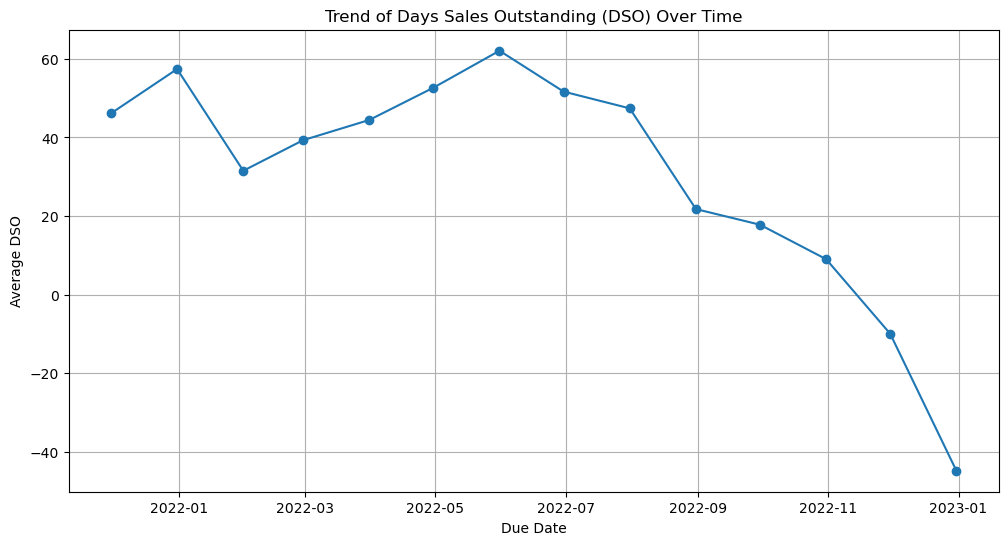

In [30]:

# Create a temporary DataFrame to avoid warnings
temp_df = df.copy()

# Use .loc to assign values to 'dso' column
temp_df.loc[:, 'dso'] = (temp_df['paid_on_date'] - temp_df['due_date']).dt.days

# Drop rows with missing values in 'dso' column
temp_df = temp_df.dropna(subset=['dso'])

# Aggregate DSO over time (e.g., monthly)
monthly_dso = temp_df.groupby(pd.Grouper(key='due_date', freq='M'))['dso'].mean()

# Create a time series plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_dso.index, monthly_dso, marker='o', linestyle='-')
plt.title('Trend of Days Sales Outstanding (DSO) Over Time')
plt.xlabel('Due Date')
plt.ylabel('Average DSO')
plt.grid(True)
plt.show()


In [31]:
# Initialize the Dash app
app = Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    html.H1("Days Sales Outstanding (DSO) Trend"),

    # Line plot for DSO trend
    dcc.Graph(id='dso-trend-plot'),

    # Range slider for selecting date range
    dcc.RangeSlider(
        id='date-range-slider',
        min=temp_df['issue_date'].min(),
        max=temp_df['issue_date'].max(),
        step=None,
        marks={str(date): str(date) for date in temp_df['issue_date'].unique()},
        value=[temp_df['issue_date'].min(), temp_df['issue_date'].max()]
    ),
])

# Define callback to update the plot based on the selected date range
@app.callback(
    Output('dso-trend-plot', 'figure'),
    [Input('date-range-slider', 'value')]
)
def update_dso_plot(selected_date_range):
    start_date, end_date = pd.to_datetime(selected_date_range[0]), pd.to_datetime(selected_date_range[1])
    filtered_df = temp_df[(temp_df['issue_date'] >= start_date) & (temp_df['issue_date'] <= end_date)]

    fig = px.line(filtered_df, x='issue_date', y='days_delinquent',
                  title='Days Sales Outstanding (DSO) Trend',
                  labels={'days_delinquent': 'DSO'},
                  line_shape='linear')  # Change line_shape if needed

    # Customize the layout
    fig.update_layout(
        xaxis_title='Issue Date',
        yaxis_title='DSO',
        hovermode='x'
    )

    return fig


# Run the app
if __name__ == '__main__':
    app.run_server(mode='inline', port=8049)

## 5. How would you categorise an invoice that is unlikely to be paid?What would be the trend month-over-month for the amount that this hypothetical client should write-off?

critiera:

* if the invoice not paid within payment term 120 days (`days_delinquent`)
* invoice cross more than acceptable payment timeline
* payer has history of not paid invoice 


In [32]:
# Set the threshold_days
threshold_days = 120

# Filter unlikely-to-pay df
filter_condition = df['days_delinquent'] > threshold_days
unlikely_to_pay_df = df.loc[filter_condition].copy()

# Convert 'issue_date' to datetime if not already
unlikely_to_pay_df.loc[:, 'issue_date'] = pd.to_datetime(unlikely_to_pay_df['issue_date'])

# Convert 'issue_date' to string for serialization
unlikely_to_pay_df.loc[:, 'issue_date_str'] = unlikely_to_pay_df['issue_date'].dt.to_period("M").astype(str)

# Calculate month-over-month trends
trend_month_over_month = unlikely_to_pay_df.groupby('issue_date_str')['total_amount'].sum().reset_index()

# Initialize Dash app
app = Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    html.H1("Month-over-Month Trends for Unlikely-to-Pay Customers"),
    
    dcc.Graph(
        id='line-chart',
        figure={
            'data': [
                {'x': trend_month_over_month['issue_date_str'], 'y': trend_month_over_month['total_amount'], 'type': 'line', 'name': 'Total Amount'},
            ],
            'layout': {
                'title': 'Month-over-Month Trends',
                'xaxis': {'title': 'Issue Date'},
                'yaxis': {'title': 'Total Amount'},
            }
        }
    )
])

# Run the app
if __name__ == '__main__':
    app.run_server(mode='inline', port=8049)

print(trend_month_over_month)

C:\Users\nithi\AppData\Local\Temp\ipykernel_21344\3322747298.py:12: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



   issue_date_str  total_amount
0         2021-11      42720266
1         2021-12      53887914
2         2022-01     159750865
3         2022-02     208689208
4         2022-03     238206320
5         2022-04     166149353
6         2022-05     177351382
7         2022-06     150060489
8         2022-07     136494757
9         2022-08     205092432
10        2022-09     332182302
11        2022-10     464526690


In [33]:
df.head()

,id,total_amount,amount_due,issue_date,due_date,paid_on_date,payer_id,invoice_category,payer_category,days_delinquent,Trend
0,1,1720329,0.0,2021-11-01 00:00:00+00:00,2021-12-31 00:00:00+00:00,2022-08-22 00:00:00+00:00,pKey9MQ59wyF6GhjWM5p,Delay paid Invoice,Delay paid Payer,234,Deteriorating
1,2,1560727,0.0,2021-11-01 00:00:00+00:00,2021-12-01 00:00:00+00:00,2021-12-04 00:00:00+00:00,Ed9wuAC3RlOfWkENchdD,Delay paid Invoice,Delay paid Payer,3,Deteriorating
2,3,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8,Deteriorating
3,4,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8,Deteriorating
4,5,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8,Deteriorating


In [34]:
ml_df = df.copy()
mldf = df.copy()


# 6 Based on month-over-month data, can you create a model to predict the revenue for the next 3 months for the hypothetical client?


In [52]:
#import 

from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA


In [36]:
mldf['date'] = pd.to_datetime(mldf['issue_date'])  # Assuming UTC, adjust if necessary
mldf['revenue_realized'] = mldf['total_amount'] - mldf['amount_due']
mldf['due_date'] = pd.to_datetime(mldf['due_date'])
mldf['days_to_due'] = (mldf['due_date'] - mldf['date']).dt.days
# Set 'date' as the index for time-based splitting
mldf.set_index('date', inplace=True)

In [37]:
mldf.head()

,id,total_amount,amount_due,issue_date,due_date,paid_on_date,payer_id,invoice_category,payer_category,days_delinquent,Trend,revenue_realized,days_to_due
date,,,,,,,,,,,,,
2021-11-01 00:00:00+00:00,1,1720329,0.0,2021-11-01 00:00:00+00:00,2021-12-31 00:00:00+00:00,2022-08-22 00:00:00+00:00,pKey9MQ59wyF6GhjWM5p,Delay paid Invoice,Delay paid Payer,234,Deteriorating,1720329.0,60
2021-11-01 00:00:00+00:00,2,1560727,0.0,2021-11-01 00:00:00+00:00,2021-12-01 00:00:00+00:00,2021-12-04 00:00:00+00:00,Ed9wuAC3RlOfWkENchdD,Delay paid Invoice,Delay paid Payer,3,Deteriorating,1560727.0,30
2021-11-01 00:00:00+00:00,3,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8,Deteriorating,149600.0,105
2021-11-01 00:00:00+00:00,4,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8,Deteriorating,149600.0,105
2021-11-01 00:00:00+00:00,5,149600,0.0,2021-11-01 00:00:00+00:00,2022-02-14 00:00:00+00:00,2022-02-22 00:00:00+00:00,bPBZIvFiIE1ZbZjvuYm7,Delay paid Invoice,Delay paid Payer,8,Deteriorating,149600.0,105


In [38]:
# Select relevant features for the model
features = ['total_amount', 'amount_due', 'days_delinquent', 'days_to_due', 'revenue_realized']


In [39]:
# Split the data into training and testing sets
train_size = int(len(mldf) * 0.8)
train, test = mldf[:train_size], mldf[train_size:]


                      month  rf_predictions
0 2022-11-01 00:00:00+00:00        60157.56
1 2022-12-01 00:00:00+00:00        70141.21
2 2023-01-01 00:00:00+00:00        52819.69


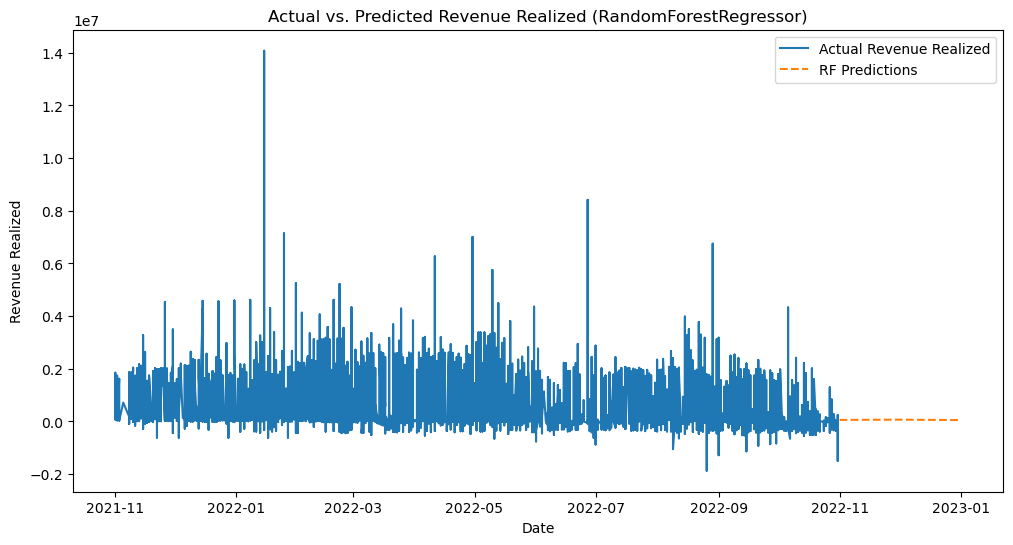

In [40]:
# RF model

# RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train[features], train['revenue_realized'])

# Predict next 3 months
next_3_months = 3
rf_next_3_months = rf_model.predict(mldf[features].tail(next_3_months))

# Create a DataFrame for the predictions
rf_predictions_df = pd.DataFrame({
    'month': pd.date_range(mldf.index[-1] + pd.DateOffset(1), periods=next_3_months, freq='MS'),
    'rf_predictions': rf_next_3_months
})

# Display the RandomForestRegressor predictions
print(rf_predictions_df)

# Plot actual vs. predicted values using RandomForestRegressor
plt.figure(figsize=(12, 6))
plt.plot(mldf.index, mldf['revenue_realized'], label='Actual Revenue Realized')
plt.plot(rf_predictions_df['month'], rf_predictions_df['rf_predictions'], label='RF Predictions', linestyle='dashed')
plt.title('Actual vs. Predicted Revenue Realized (RandomForestRegressor)')
plt.xlabel('Date')
plt.ylabel('Revenue Realized')
plt.legend()
plt.show()

c:\Users\nithi\mambaforge\envs\boomi\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\nithi\mambaforge\envs\boomi\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\nithi\mambaforge\envs\boomi\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\nithi\mambaforge\envs\boomi\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



                          month  sarimax_predictions
17692 2022-11-01 00:00:00+00:00        184176.268399
17693 2022-12-01 00:00:00+00:00        201494.399050
17694 2023-01-01 00:00:00+00:00        189254.873233


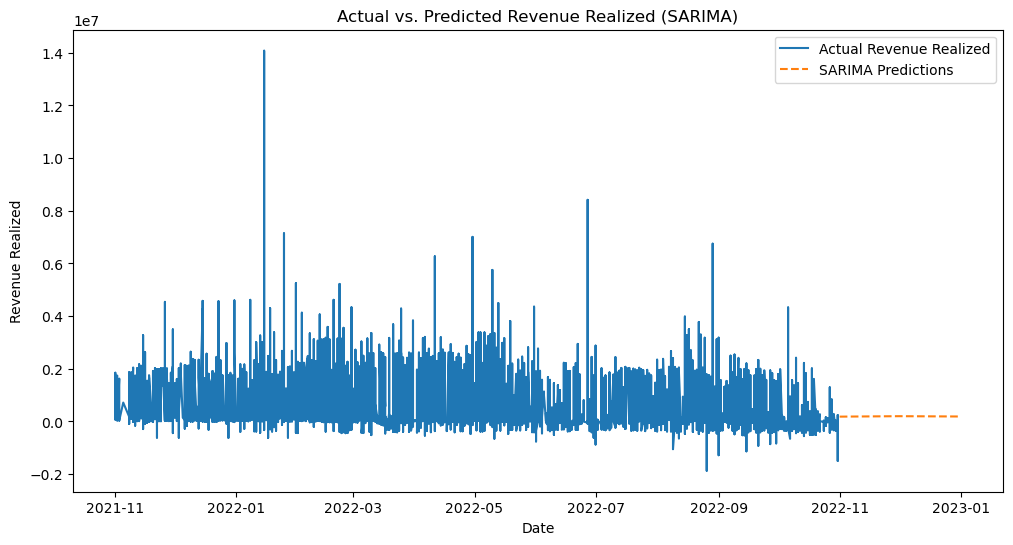

In [46]:
# SARIMAX model
sarimax_model = SARIMAX(train['revenue_realized'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_fit = sarimax_model.fit(disp=False)

# Predict next 3 months with SARIMA
next_3_months = 3
sarimax_next_3_months = sarimax_fit.predict(start=len(mldf), end=len(mldf) + next_3_months - 1, dynamic=False)

# Create a DataFrame for the SARIMA predictions
sarima_predictions_df = pd.DataFrame({
    'month': pd.date_range(mldf.index[-1] + pd.DateOffset(1), periods=next_3_months, freq='MS'),
    'sarimax_predictions': sarimax_next_3_months
})

# Display the SARIMA predictions
print(sarima_predictions_df)

# Plot actual vs. predicted values with SARIMA
plt.figure(figsize=(12, 6))
plt.plot(mldf.index, mldf['revenue_realized'], label='Actual Revenue Realized')
plt.plot(sarima_predictions_df['month'], sarima_predictions_df['sarimax_predictions'], label='SARIMA Predictions', linestyle='dashed')
plt.title('Actual vs. Predicted Revenue Realized (SARIMA)')
plt.xlabel('Date')
plt.ylabel('Revenue Realized')
plt.legend()
plt.show()

c:\Users\nithi\mambaforge\envs\boomi\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\nithi\mambaforge\envs\boomi\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\nithi\mambaforge\envs\boomi\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\nithi\mambaforge\envs\boomi\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\nithi\mambaforge\envs\boomi\Lib\site-packages\statsmodels\tsa\base

                          month  arima_predictions
17692 2022-11-01 00:00:00+00:00      223090.614858
17693 2022-12-01 00:00:00+00:00      223090.614858
17694 2023-01-01 00:00:00+00:00      223090.614858


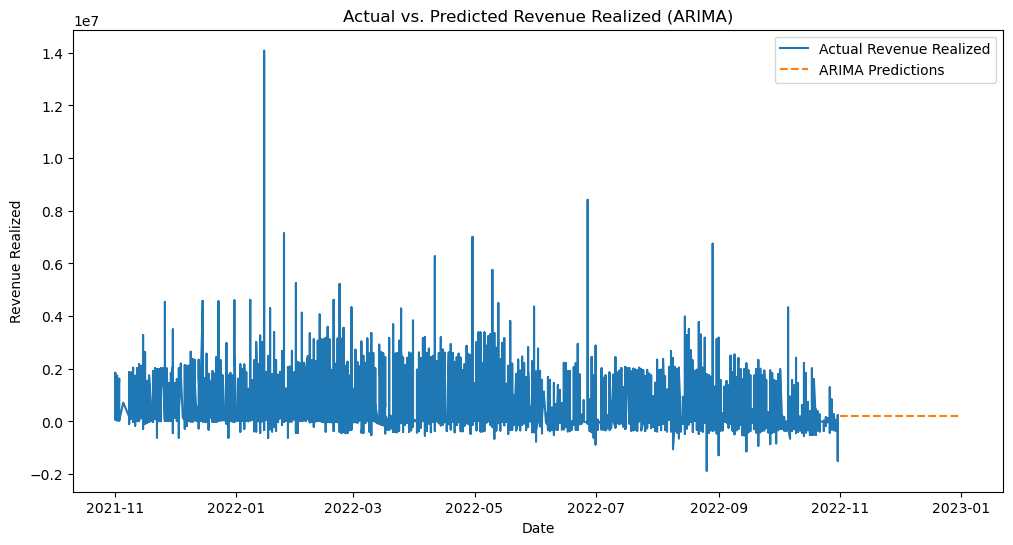

In [49]:

# ARIMA model
order = (1, 1, 1)  # Adjust order as needed
arima_model = ARIMA(train['revenue_realized'], order=order)
arima_fit = arima_model.fit()

# Predict next 3 months with ARIMA
next_3_months = 3
arima_next_3_months = arima_fit.predict(start=len(mldf), end=len(mldf) + next_3_months - 1, dynamic=False)

# Create a DataFrame for the ARIMA predictions
arima_predictions_df = pd.DataFrame({
    'month': pd.date_range(mldf.index[-1] + pd.DateOffset(1), periods=next_3_months, freq='MS'),
    'arima_predictions': arima_next_3_months
})

# Display the ARIMA predictions
print(arima_predictions_df)

# Plot actual vs. predicted values with ARIMA
plt.figure(figsize=(12, 6))
plt.plot(mldf.index, mldf['revenue_realized'], label='Actual Revenue Realized')
plt.plot(arima_predictions_df['month'], arima_predictions_df['arima_predictions'], label='ARIMA Predictions', linestyle='dashed')
plt.title('Actual vs. Predicted Revenue Realized (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Revenue Realized')
plt.legend()
plt.show()

In [50]:

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame({
    'date': pd.date_range(mldf.index[-1] + pd.DateOffset(1), periods=3, freq='MS'),
    'rf_predictions': rf_next_3_months,
    'sarimax_predictions': sarimax_next_3_months,
    'arima_predictions': arima_next_3_months
})

# Display the predictions
print(predictions_df[['date', 'rf_predictions', 'sarimax_predictions', 'arima_predictions']])

                           date  rf_predictions  sarimax_predictions  \
17692 2022-11-01 00:00:00+00:00        60157.56        184176.268399   
17693 2022-12-01 00:00:00+00:00        70141.21        201494.399050   
17694 2023-01-01 00:00:00+00:00        52819.69        189254.873233   

       arima_predictions  
17692      223090.614858  
17693      223090.614858  
17694      223090.614858  
